In [1]:
import sys, os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
os.chdir('game-behavior-analytics/data_analysis_notebook/')

In [2]:
# =============================================================================
# 1. DATA LOADING AND PREPARATION
# =============================================================================

sys.path.append(os.path.abspath('utils'))

warnings.filterwarnings('ignore')

# Now you can import the utility function
from data_utils import load_and_prepare_data
from metadata import theory_order, theory_map

# Load and preprocess your data
df, concepts = load_and_prepare_data("../data/final_dataset.csv")

In [5]:
# =============================================================================
# 2. RQ3: EXPERIENCE MODEL
# =============================================================================

def build_experience_model(df, concepts):
    with pm.Model() as model:
        # Intercepts for each cheating behavior category (0 = none, 1 = partial, 2 = full)
        intercepts_by_cheating_level = pm.Normal(
            'intercepts_by_cheating_level', mu=0, sigma=10, shape=3
        )

        # Overall group-level mean and variability of concept effects on experience
        mean_concept_effect = pm.Normal('mean_concept_effect', mu=0, sigma=2)
        sd_concept_effect = pm.HalfNormal('sd_concept_effect', sigma=2)

        # Main effect of each concept (e.g., autonomy, norms) on task experience
        concept_main_effects = pm.Normal(
            'concept_main_effects',
            mu=mean_concept_effect,
            sigma=sd_concept_effect,
            shape=len(concepts)
        )

        # Group-level priors for concept × cheating interaction effects
        mean_concept_cheating_interactions = pm.Normal(
            'mean_concept_cheating_interactions', mu=0, sigma=2, shape=3
        )
        sd_concept_cheating_interactions = pm.HalfNormal(
            'sd_concept_cheating_interactions', sigma=2, shape=3
        )

        # Interaction effect of each concept with each cheating category
        concept_cheating_interactions = pm.Normal(
            'concept_cheating_interactions',
            mu=mean_concept_cheating_interactions,
            sigma=sd_concept_cheating_interactions,
            shape=(len(concepts), 3)
        )

        # Base predicted experience by cheating level
        predicted_mu = intercepts_by_cheating_level[df['cheating_behavior'].values]

        # Add concept effects (only for intervention groups, concept_idx > 0)
        concept_effect = pm.math.switch(
            df['concept_idx'].values > 0,
            concept_main_effects[df['concept_idx'].values - 1] +
            concept_cheating_interactions[df['concept_idx'].values - 1, df['cheating_behavior'].values],
            0
        )

        predicted_mu += concept_effect

        # Residual (unexplained) variability in experience ratings
        residual_sd = pm.HalfNormal('residual_sd', sigma=2)

        # Observed experience ratings, assumed bounded between 1 and 7
        pm.TruncatedNormal(
            'experience_observed',
            mu=predicted_mu,
            sigma=residual_sd,
            lower=1,
            upper=7,
            observed=df['experience'].values
        )

    return model


In [6]:
def sample_experience_model(model, **kwargs):
    with model:
        trace = pm.sample(
            draws=kwargs.get("draws", 1500),
            tune=kwargs.get("tune", 2000),
            chains=kwargs.get("chains", 4),
            cores=kwargs.get("cores", 4),
            target_accept=kwargs.get("target_accept", 0.9),
            max_treedepth=kwargs.get("max_treedepth", 12),
            init=kwargs.get("init", "jitter+adapt_diag"),
            random_seed=kwargs.get("random_seed", 42)
        )
    return trace

In [7]:
print("Fitting RQ3: Experience Model...")
experience_model = build_experience_model(df, concepts)
trace_experience = sample_experience_model(experience_model)
print("Done.")

Fitting RQ3: Experience Model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercepts_by_cheating_level, mean_concept_effect, sd_concept_effect, concept_main_effects, mean_concept_cheating_interactions, sd_concept_cheating_interactions, concept_cheating_interactions, residual_sd]


Output()

Sampling 4 chains for 2_000 tune and 1_500 draw iterations (8_000 + 6_000 draws total) took 1404 seconds.
There were 356 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Done.


In [16]:
az.to_netcdf(trace_experience, "notebook/trace_experience.nc")

'notebook/trace_experience.nc'

In [8]:
with experience_model:
    ppc_experience_prior = pm.sample_prior_predictive(model=experience_model)
    ppc_experience_posterior = pm.sample_posterior_predictive(trace_experience, random_seed=42)

Sampling: [concept_cheating_interactions, concept_main_effects, experience_observed, intercepts_by_cheating_level, mean_concept_cheating_interactions, mean_concept_effect, residual_sd, sd_concept_cheating_interactions, sd_concept_effect]
Sampling: [experience_observed]


Output()

<Axes: xlabel='experience_observed'>

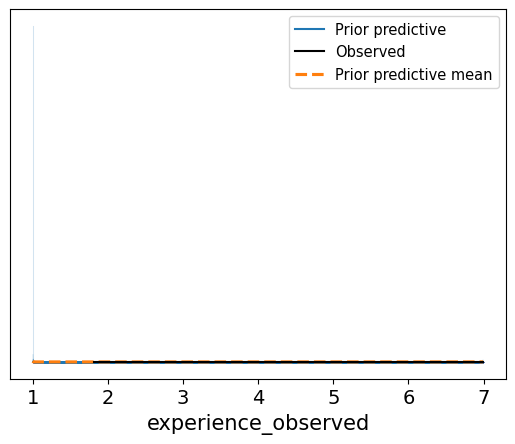

In [9]:
az.plot_ppc(ppc_experience_prior, group='prior', observed=True)

<Axes: xlabel='experience_observed'>

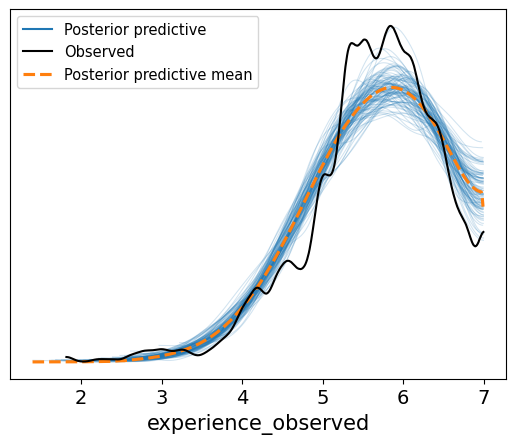

In [10]:
az.plot_ppc(ppc_experience_posterior, num_pp_samples=100)

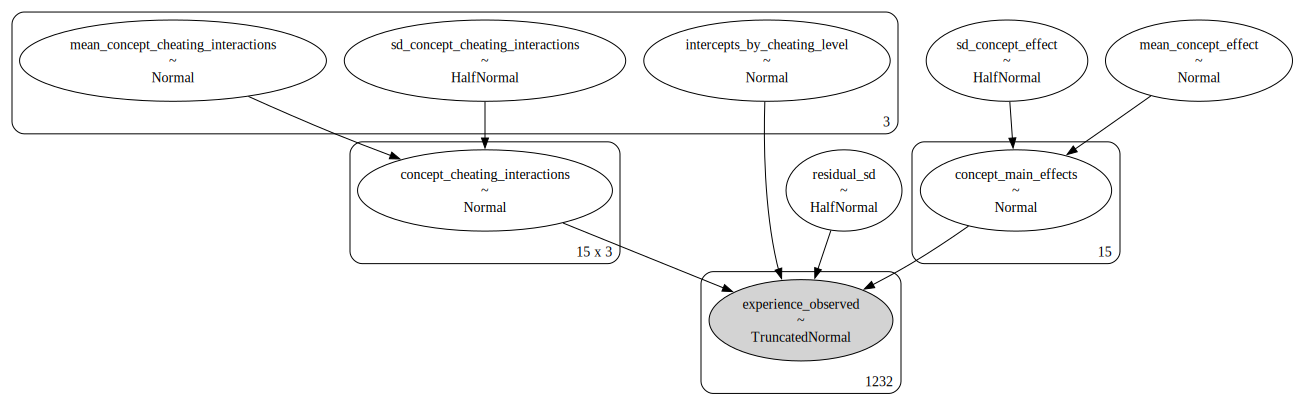

In [11]:
pm.model_to_graphviz(experience_model)

In [12]:
# =============================================================================
# 3. RQ3 RESULTS: Posterior Extraction + Summary
# =============================================================================

def summarize_experience_effects(trace, concepts, theory_order, theory_map):
    """Summarizes posterior changes in experience by concept."""
    
    # Extract posterior samples
    control_means = trace.posterior['intercepts_by_cheating_level'].values.reshape(-1, 3)
    concept_main = trace.posterior['concept_main_effects'].values.reshape(-1, len(concepts))
    concept_interactions = trace.posterior['concept_cheating_interactions'].values.reshape(-1, len(concepts), 3)

    # By-concept differences
    results = []
    for concept in theory_order:
        if concept not in concepts:
            continue
        idx = concepts.index(concept)

        differences = {}
        for cheat_cat in [0, 1, 2]:
            control_baseline = control_means[:, cheat_cat]
            intervention_effect = (control_baseline + 
                                 concept_main[:, idx] + 
                                 concept_interactions[:, idx, cheat_cat])
            diff = intervention_effect - control_baseline
            differences[cheat_cat] = diff

        results.append({
            'Concept': concept.replace('_', ' ').title(),
            'Theory': theory_map[concept],
            'Non_mean': differences[0].mean(),
            'Non_hdi': az.hdi(differences[0], hdi_prob=0.95),
            'Partial_mean': differences[1].mean(),
            'Partial_hdi': az.hdi(differences[1], hdi_prob=0.95),
            'Full_mean': differences[2].mean(),
            'Full_hdi': az.hdi(differences[2], hdi_prob=0.95),
        })

    df_results = pd.DataFrame(results)

    # Overall average effect across all concepts
    overall_effects = {}
    for cheat_cat in [0, 1, 2]:
        all_concept_effects = []
        for i in range(len(concepts)):
            control_baseline = control_means[:, cheat_cat]
            intervention_effect = (control_baseline + 
                                 concept_main[:, i] + 
                                 concept_interactions[:, i, cheat_cat])
            diff = intervention_effect - control_baseline
            all_concept_effects.append(diff)
        
        overall_diff = np.mean(all_concept_effects, axis=0)
        overall_effects[cheat_cat] = {
            'mean': overall_diff.mean(),
            'hdi': az.hdi(overall_diff, hdi_prob=0.95)
        }

    control_baselines = {
        'Non': control_means[:, 0].mean(),
        'Partial': control_means[:, 1].mean(),
        'Full': control_means[:, 2].mean()
    }

    return df_results, overall_effects, control_baselines

In [13]:
def print_experience_results_table(df_results):
    print("\nRQ3: EXPERIENCE CHANGES (points) with 95% HDI:")
    print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial':<25} {'Full':<25}")
    print("-" * 130)

    for _, row in df_results.iterrows():
        non = f"{row['Non_mean']:+.2f} [{row['Non_hdi'][0]:+.2f}, {row['Non_hdi'][1]:+.2f}]"
        partial = f"{row['Partial_mean']:+.2f} [{row['Partial_hdi'][0]:+.2f}, {row['Partial_hdi'][1]:+.2f}]"
        full = f"{row['Full_mean']:+.2f} [{row['Full_hdi'][0]:+.2f}, {row['Full_hdi'][1]:+.2f}]"
        print(f"{row['Concept']:<35} {row['Theory']:<30} {non:<25} {partial:<25} {full:<25}")


In [14]:
# Execute analysis
df_results_experience, overall_results_experience, control_baselines_experience = summarize_experience_effects(
    trace_experience, concepts, theory_order, theory_map
)

print_experience_results_table(df_results_experience)


RQ3: EXPERIENCE CHANGES (points) with 95% HDI:
Concept                             Theory                         Non-cheater               Partial                   Full                     
----------------------------------------------------------------------------------------------------------------------------------
Autonomy                            Self-Determination Theory      +0.13 [-0.27, +0.54]      -0.20 [-1.01, +0.58]      +0.17 [-0.36, +0.76]     
Competence                          Self-Determination Theory      +0.06 [-0.38, +0.46]      -0.23 [-1.07, +0.55]      +0.15 [-0.41, +0.68]     
Relatedness                         Self-Determination Theory      +0.13 [-0.30, +0.52]      -0.32 [-1.13, +0.52]      +0.13 [-0.40, +0.67]     
Self Concept                        Cognitive Dissonance Theory    +0.14 [-0.26, +0.56]      -0.16 [-0.99, +0.63]      +0.09 [-0.46, +0.64]     
Cognitive Inconsistency             Cognitive Dissonance Theory    +0.14 [-0.29, +0.54]      -0.

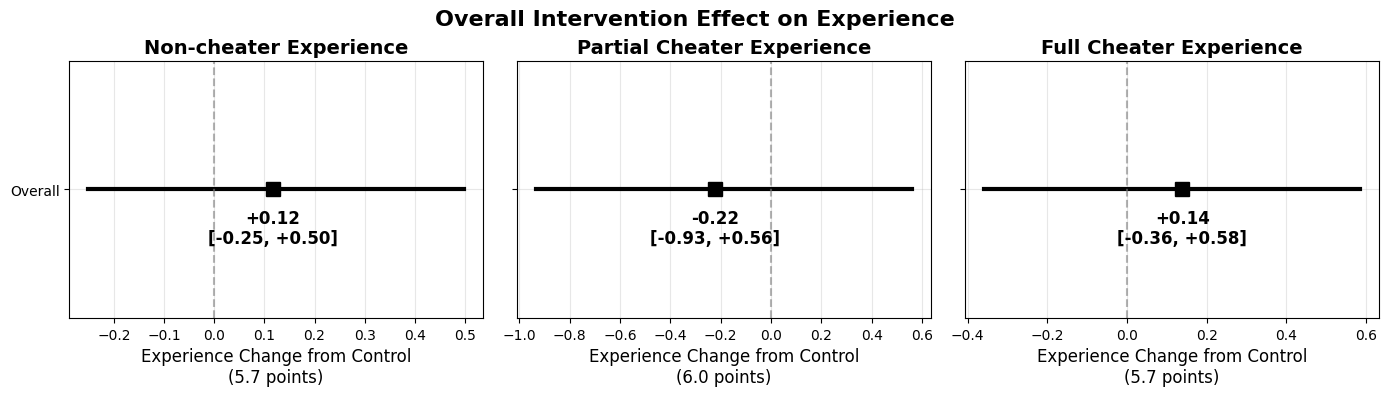

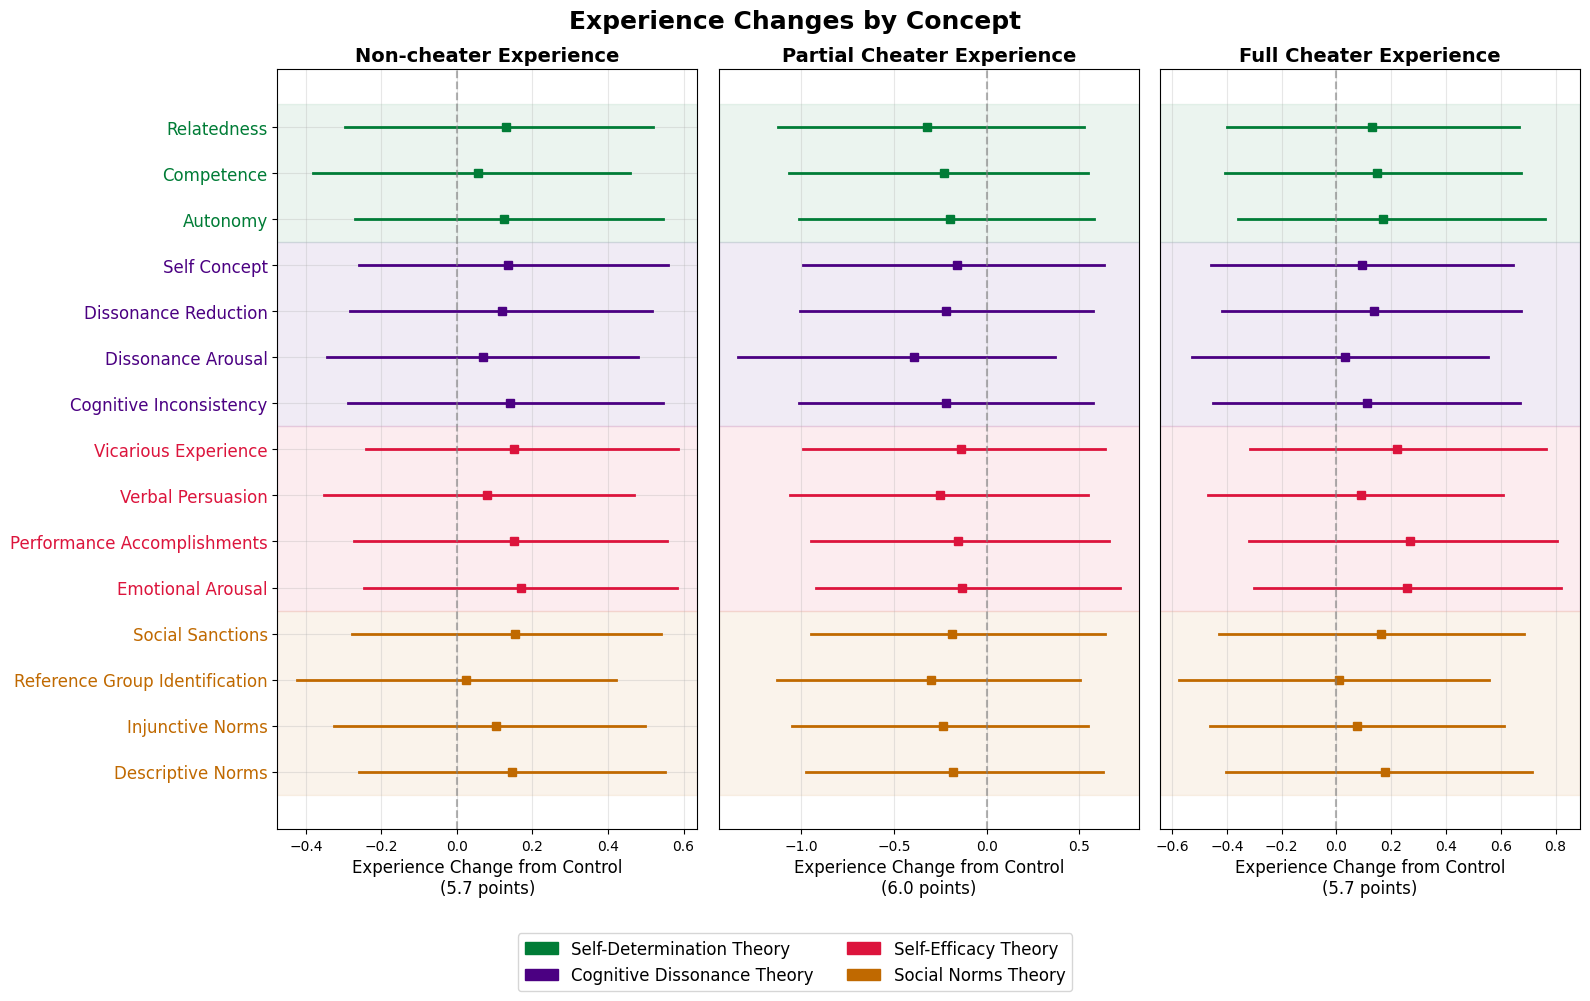

In [15]:
# =================
# FOREST PLOTS
# =================

import matplotlib.patches as patches

def plot_experience_forest(df_results, overall_results, control_baselines):
    categories = ['Non', 'Partial', 'Full']
    titles = ['Non-cheater Experience', 'Partial Cheater Experience', 'Full Cheater Experience']
    outcome_name = 'Experience'
    units = 'pts'
    
    theory_order_viz = ['Social Norms Theory', 'Self-Efficacy Theory', 'Cognitive Dissonance Theory', 'Self-Determination Theory']
    theory_colors = {
        'Self-Determination Theory': "#007C36",
        'Cognitive Dissonance Theory': '#4B0082',
        'Self-Efficacy Theory': '#DC143C',
        'Social Norms Theory': "#C06900"
    }

    # ---------------- Overall Effects ----------------
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    for idx, cat in enumerate(categories):
        ax = axes[idx]
        mean = overall_results[idx]['mean']
        hdi = overall_results[idx]['hdi']
        
        ax.plot([hdi[0], hdi[1]], [0, 0], color='black', lw=3)
        ax.plot(mean, 0, 's', color='black', markersize=10)
        ax.text(mean, -0.15, f'{mean:+.2f}\n[{hdi[0]:+.2f}, {hdi[1]:+.2f}]', 
                ha='center', va='center', fontweight='bold', fontsize=12)
        
        ax.axvline(0, color='gray', linestyle='--', alpha=0.6)
        ax.set_title(titles[idx], fontsize=14, fontweight='bold')
        ax.set_xlabel(f"{outcome_name} Change from Control\n({control_baselines[cat]:.1f} points)", fontsize=12)
        
        ax.set_yticks([0])
        ax.set_yticklabels(['Overall'] if idx == 0 else [])
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.5, 0.5)
    plt.suptitle(f'Overall Intervention Effect on {outcome_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    # ---------------- By-Concept Effects ----------------
    df_results['Theory'] = pd.Categorical(df_results['Theory'], categories=theory_order_viz, ordered=True)
    df_sorted = df_results.sort_values(['Theory', 'Concept']).reset_index(drop=True)
    y_pos = np.arange(len(df_sorted))

    fig, axes = plt.subplots(1, 3, figsize=(16, 10))
    for idx, cat in enumerate(categories):
        ax = axes[idx]
        means = df_sorted[f'{cat}_mean']
        hdis = np.array([x for x in df_sorted[f'{cat}_hdi']])

        # Background shading
        for theory in theory_order_viz:
            inds = df_sorted.index[df_sorted['Theory'] == theory]
            if not inds.empty:
                ax.axhspan(inds[0]-0.5, inds[-1]+0.5, color=theory_colors[theory], alpha=0.08)

        # Forest bars
        for i, (mean, hdi, theory) in enumerate(zip(means, hdis, df_sorted['Theory'])):
            color = theory_colors[theory]
            ax.plot([hdi[0], hdi[1]], [i, i], color=color, lw=2)
            ax.plot(mean, i, 's', color=color, markersize=6)

        ax.axvline(0, color='gray', linestyle='--', alpha=0.6)
        ax.set_title(titles[idx], fontsize=14, fontweight='bold')
        ax.set_xlabel(f"{outcome_name} Change from Control\n({control_baselines[cat]:.1f} points)", fontsize=12)
        ax.grid(True, alpha=0.3)
        
        if idx == 0:
            ax.set_yticks(y_pos)
            ax.set_yticklabels(df_sorted['Concept'], fontsize=12)
            for tick, theory in zip(ax.get_yticklabels(), df_sorted['Theory']):
                tick.set_color(theory_colors[theory])
        else:
            ax.set_yticks([])
    plt.suptitle(f'{outcome_name} Changes by Concept', fontsize=18, fontweight='bold', y=0.94)

    # Legend
    legend_handles = [patches.Patch(color=color, label=theory) for theory, color in theory_colors.items()]
    fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.12)
    plt.show()

plot_experience_forest(df_results_experience, overall_results_experience, control_baselines_experience)